# La Palma Lava Mapping Toolkit

**A toolkit for the semi-automatic mapping of lava, based on the 2021 La Palma *Cumbre Vieja* eruption, using Sentinel-1 data**

Creator: [Luke McQuade](https://github.com/lukesdm) @ [Z_GIS](https://www.plus.ac.at/geoinformatik/?lang=en), as part of the [Copernicus Master in Digtial Earth](https://www.master-cde.eu/) programme.

## Introduction

On Sunday 19th September 2021, the Canarian island of La Palma experienced a stratovolcanic eruption on the Cumbre Veija ridge. The eruption lasted until Tuesday 13th December - almost 3 months. Due to early detection and action of the local authorities, there was no direct loss of human life. However, there was significant damage to infrastructure, buildings and land ([Carracedo, Troll et al, 2022](https://onlinelibrary.wiley.com/doi/10.1111/gto.12388)).

Eruptions are often accompanied by large amounts of smoke and particulates, which can reduce the effectiveness of optical imaging satellites for monitoring. The [Copernicus Sentinel-1](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-1) synthetic aperture radar (SAR) mission, whose data is freely available, has the ability to penetrate clouds, darkness and smoke plumes and so can be an effective tool in these situations. This data can be notoriously difficult to interpret, however.

An approach based on the tools and principles of [GEOBIA](https://gisgeography.com/obia-object-based-image-analysis-geobia/) is presented here for the semi-automatic mapping/classification of active lava flows - initially for the La Palma *Cumbre Vieja* event, with transferability still to be investigated.

This notebook will demonstrate the process, which involves segmentation, feature engineering and knowledge-based classification.

### About the notebook

There are some interactive sections, indicated by 📝, where user input is required. Some reasonable defaults have been chosen though, if you just want to run all the cells in one go.

This is experimental, unoptimised code, and some cells will take some time to run. ⏱ indicates such cells.

The notebook has been designed to allow you to re-try the workflow with different options. Change the desired parameter value, and run the subsequent cells to see the new results.

## Setup

### Import dependencies

In [71]:
import matplotlib.pyplot as plt
from ipywidgets import interact

import lplm_geoprocessing as lpgeo
import lplm_io as lpio
import lplm_presentation as lpp
import lplm_utils as lpu
import lplm_eda as lpe

In [72]:
# Run this to reload custom modules after making changes 
import importlib
importlib.reload(lpgeo)
importlib.reload(lpio)
importlib.reload(lpp)
importlib.reload(lpu)
importlib.reload(lpe)

<module 'lplm_eda' from '/home/jovyan/lplm/lplm_eda.py'>

### Load a map

In [73]:
# Map inputs needs to be passed in as EPSG:4326 even though map CRS is EPSG:3857. 
map_center = ( (28.58 + 28.65) / 2, (-17.97 + -17.84) / 2)
 
from sidecar import Sidecar
from ipyleaflet import Map, LayersControl, projections
lp_map = Map(
    center=map_center,
    zoom=13,
    crs=projections.EPSG3857,
    scroll_wheel_zoom=True)
lp_map.add_control(LayersControl())
sc = Sidecar()
with sc:
    display(lp_map)

## 📝 Explore the imagery and choose a date

The dataset is a series of Sentinel-1 ground-range-detected (GRD) images captured on the dates before, during and after the eruption, with the following characteristics (see [*About Sentinel-1 GRD Data*](https://docs.sentinel-hub.com/api/latest/data/sentinel-1-grd/) for an explanation of these):
* Acquisition mode: Interferometric wide swath (IW)  
* Signal type: Backscatter intensity (linear) - $\gamma_{0}$ (radiometrically terrain corrected)   
* Polarisation: VV  
* Orbit: Ascending  
* DEM correction: 30m Mapzen  

Take a look at the images - if you view them in series, you should be able roughly make out the progression of the lava flow.

Choose an image date to perform the analysis on.

Note that '2021-09-10' and '2021-09-16' are pre-event images.

In [74]:
# Load imagery
xds_grd = lpio.load_series("data")

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.dpi"] = 100

selected_date = lpu.to_date('2021-11-15')

def view_scene(date=selected_date):
    # Use this date for the rest of the notebook
    global selected_date 
    
    layer_sar = lpp.make_sar_layer(xds_grd, date)
    lpp.replace_layer(lp_map, layer_sar, lpp.sar_layer_name(selected_date))
    selected_date = date
    # TODO: add vent layer
    
interact(view_scene, date=lpp.get_date_labels(xds_grd))

interactive(children=(Dropdown(description='date', index=10, options=(('2021-09-10', numpy.datetime64('2021-09…

<function __main__.view_scene(date=Timestamp('2021-11-15 00:00:00'))>

## ⏱ Perform segmentation

[Radar speckle](https://en.wikipedia.org/wiki/Speckle_(interference)), geometric distortions, and other properties make analysis at the single-pixel level error-prone. There are various filtering methods available that attempt to counter this. However, there is always a risk of losing spatial or textural information this way.

Try zooming in. As you can see, active lava flow can be difficult or impossible to differentiate from its surroundings. It needs to be examined with more context. [SLIC0](https://www.epfl.ch/labs/ivrl/research/slic-superpixels/) segmentation allows for this. It can be thought of as a sort of 'smart chessboard' segmentation, as it divides the image into similar sized segments, which roughly follow object borders. 

In [75]:
lpgeo.apply_segmentation(xds_grd,
                         selected_date,
                         # These values produce segments around 16-18 pixels or 160-180m across for this imagery:
                         n_segments = 5000,
                         compactness = 0.1)

gdf = lpgeo.vectorize_segments(xds_grd)

# Display results
from ipyleaflet import GeoData
# Have to convert to EPSG:4326 first, despite map CRS.
layer_seg = GeoData(
    geo_dataframe = gdf.to_crs("EPSG:4326"),
    style = { "fillOpacity": 0.0, "weight": 1.0 },
    name = "Segments")
lpp.replace_layer(lp_map, layer_seg)

## Calculate segment pixel statistics

The first step in the analysis is to determine the statistics of the segments' pixel values: the mean, which is heavily influenced by surface type, and the standard deviation, which is a rough indicator of texture.

In [76]:
xds_segstats = lpgeo.segment_stats(xds_grd)

lpgeo.enrich_stats(gdf, xds_segstats, selected_date)

# TODO: show a layer here

## 📝 Select a reference sample

Hopefully, through visual inspection of a series of images, you will be able to identify an area that is clearly part of the active lava flow. Drag the sampling rectangle to choose a reference sample. 

In [77]:
# Choose sample area
from ipyleaflet import Polygon

layer_sample_poly = Polygon(
    name="Sample area - lava",
    locations=[
        (28.61279608, -17.90567758),
        (28.61279608, -17.88789544),
        (28.62486374, -17.88789544),
        (28.62486374, -17.90567758)
    ], transform=True)

lpp.replace_layer(lp_map, layer_sample_poly)

# Note: there seems to be a bug in ipyleaflet that leaves the handles after removing or hiding the layer.

The statistics of the underlying segments will guide the classification. The cell below calculates these. You may wish to adjust your sample selection and try again.

In [78]:
# Find matching segments
from shapely import geometry

# Initial and manually-adjusted polygon have different point data layouts. So have to handle both.
try:
    shapely_sample_4326 = geometry.Polygon([(pdict["lng"], pdict["lat"]) for pdict in layer_sample_poly.locations[0]])
except:
    shapely_sample_4326 = geometry.Polygon([(lon, lat) for (lat, lon) in layer_sample_poly.locations])
# gds_sample_3857 = geopandas.GeoSeries(shapely_sample_4326, crs="EPSG:4326").to_crs("EPSG:3857")
# For some reason, doing the intersection calc in EPSG:3857 doesn't always work - could be the point ordering in the polygon?
# So, as a workaround just do it in EPSG:4326.
gdf_4326 = gdf.to_crs("EPSG:4326")
gdf_sample_4326 = gdf_4326.loc[gdf_4326.intersects(shapely_sample_4326)]

# Display the result
from ipyleaflet import GeoData
layer_sample = GeoData(geo_dataframe=gdf_sample_4326, name="Sample segments - lava")
lpp.replace_layer(lp_map, layer_sample)

### Inspect distributions

The cell below will pick a few segments from the sample (sub-sample), and show the distributions of their $\gamma_{0}\$ pixel values. Running it again will choose a different set of segments.

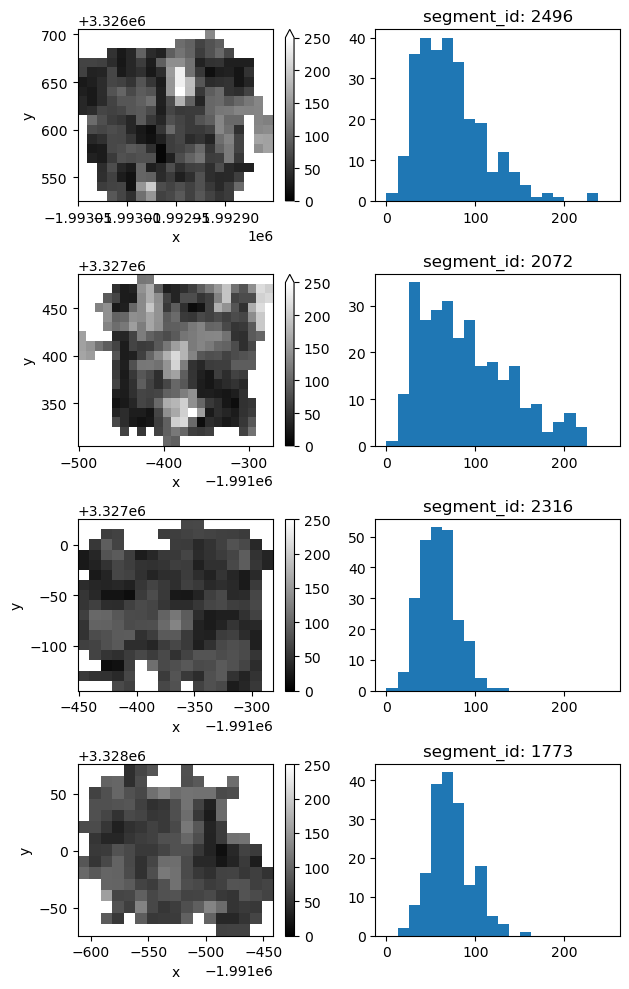

In [79]:
sample_segids = gdf_sample_4326["segment_id"].sample(4).values
lpe.plot_segment_histos(xds_grd, sample_segids, selected_date)

Now, run the cell below and inspect the distributions of segment means and standard deviations over the entire sample.

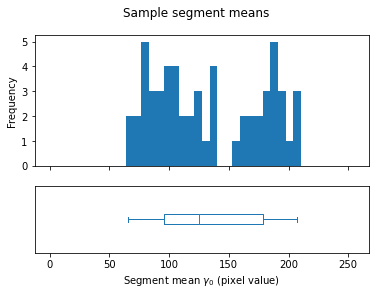

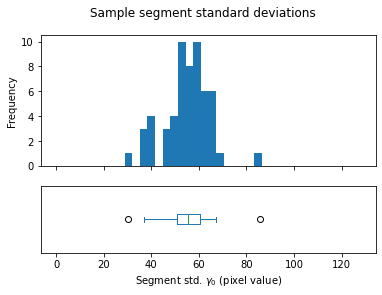

In [70]:
lpe.plot_segment_stats_dists(gdf_sample_4326)

You may wish to repeat the past few steps for areas *outside* the lava flow for comparison. Remember to make your final sample is within the flow though, as it is used in the subsequent calculations.

### Calculate lava-likeness metrics

...

In [40]:
# This might take a while.
lpgeo.enrich_lava_likeness(gdf, gdf_sample_4326.to_crs("3857"))

layer_enriched = lpp.make_feature_layer(gdf, "local_lava_likeness")

lpp.replace_layer(lp_map, layer_enriched)

## Analysis, Part 2
Now we apply some neighbourhood-based operations to estimate the lava field.

### ❔ Choose a starting point

Choose a starting point to seed the region-growing algorithm - ideally somewhere clearly in the lava field.

In [41]:
from ipyleaflet import Marker
marker = Marker(location=map_center, draggable=True, name="Start")
lpp.replace_layer(lp_map, marker)

Find the matching segment.

In [42]:
from pyproj import Transformer
t = Transformer.from_crs("epsg:4326", "epsg:3857")
start_x, start_y = t.transform(marker.location[0], marker.location[1])
start_segment_id = lpgeo.get_segment_id(gdf, start_x, start_y)

Now, estimate the lava region.

In [43]:
# TODO: Fix warnings for this:
import warnings
warnings.filterwarnings('ignore')
lpgeo.lava_likeness_overall(gdf, start_segment_id)

gdf_lava_est = lpgeo.extract_lava_region(gdf, start_segment_id)

Show the results.

In [44]:
layer_neigh_ll = lpp.make_feature_layer(gdf, "neighbourhood_lava_likeness")

layer_lava = GeoData(
    geo_dataframe = gdf_lava_est.to_crs("EPSG:4326"),
    style = { "fillOpacity": 1.0, "weight": 1.0, "fillColor": "orange" },
    name = "Estimated lava field")

lpp.replace_layer(lp_map, layer_neigh_ll)
lpp.replace_layer(lp_map, layer_lava)

The Copernicus Emergency Rapid Mapping service provided maps through the course of the eruption. These were created with the aid of high resolution sources of various types, such as [COSMO-SkyMed](https://earth.esa.int/eogateway/missions/cosmo-skymed), a high resolution X-band SAR mission. See the [event page](https://emergency.copernicus.eu/mapping/ems/volcano-eruption-la-palma-spain) for further details. With a few of these as a reference, let's compare our results... 

In [45]:
import geopandas
ems_maps = {
    "2021-11-15": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT52_observedEventA_r1_v1.shp"),
    "2021-11-21": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT53_observedEventA_r1_v1.shp"),
    "2021-12-18": geopandas.read_file("ems-reference/EMSR546_AOI01_GRA_MONIT63_observedEventA_r1_v1.shp"),
}

def ems_layer_name(key):
    return f"EMS Rapid Mapping @ {key}"

def make_ems_layer(key):
    layer = GeoData(
        geo_dataframe = ems_maps[key].to_crs("EPSG:4326"),
        style = { "fillOpacity": 0.0, "weight": 1.0, "color": "red" },
        name = ems_layer_name(key))
    return layer

layers_ems = {}

for key in ems_maps.keys():
    layers_ems[key] = make_ems_layer(key)

selected_ems = None
    
def show_ems_layer(ems_map_date):
    global selected_ems
    lpp.replace_layer(lp_map, layers_ems[ems_map_date], ems_layer_name(selected_ems))
    selected_ems = ems_map_date
    return None
    
interact(show_ems_layer, ems_map_date=ems_maps.keys())

interactive(children=(Dropdown(description='ems_map_date', options=('2021-11-15', '2021-11-21', '2021-12-18'),…

<function __main__.show_ems_layer(ems_map_date)>